# <center> Projeto Grafos</center>

### Objetivo


Montar um grafo com as substações de energia e suas interligação, com o grafo pronto analisar as interligações, possiveis falhas, e pontos de melhoria da rede eletrica, em relação a disponibilidade e redundancia da rede.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

##### Importando os dados

In [2]:
data_frame = pd.read_csv("./siget-contrato-modulolinhatransmissao-subestacaoorigem-subestacaodestino.csv", encoding="latin", sep=";")


##### Formatando, filtrando e limpando os dados

In [3]:
data_frame.dropna(inplace=True, how="any")
# data_frame.drop(data_frame[data_frame["DscSitLinTms"] != "Ativa"].index, axis=0, inplace=True)
data_frame.drop(["DatGeracaoConjuntoDados","IdeMdl","IdeTipMdl","NomLongoSubestacaoOrigem" ,"NomLongoSubestacaoDestino"], axis=1, inplace=True)

colunas_arestas = ["id", "situacao", "nome", "circuito", "qtd_torres", "sub_origem", "sub_destino"]
arestas_df = pd.DataFrame(data_frame[["IdeLinTms","DscSitLinTms", "NomLinTms", "NumCcuLinTms", "QtdTorLinTms", "IdeSbeOri", "IdeSbeDsn" ]]).set_axis(colunas_arestas, axis=1).reset_index()

colunas = ["ide", "ideOns", "nome", "uf"]

vertices_origem = pd.DataFrame(data_frame[["IdeSbeOri", "IdeOnsSbeOrigem", "NomSubestacaoOrigem", "SigUFSubestacaoOrigem"]]).set_axis(colunas, axis=1)
vertices_destino = pd.DataFrame(data_frame[["IdeSbeDsn", "IdeOnsSbeDestino", "NomSubestacaoDestino", "SigUFSubestacaoDestino"]]).set_axis(colunas, axis=1)

vertices_df = pd.concat([vertices_origem, vertices_destino]).drop_duplicates().dropna(how="any").reset_index()


##### Montando o Grafo

In [4]:
v = list()

for i in vertices_df.index:
    linha = vertices_df.iloc[i]
    v.append( (linha["ide"], { "ideOns": linha["ideOns"], "nome": linha["nome"], "uf": linha["uf"]}) )


vertices = pd.Series(v)

v.clear()

In [5]:
grafo = nx.Graph()

grafo.add_nodes_from(vertices)

In [6]:
for i in arestas_df.index:
    linha = arestas_df.iloc[i]
    grafo.add_edge((linha["sub_origem"]), linha["sub_destino"], weight=linha["qtd_torres"])

#### Com o grafo pronto vamo observar algumas coisas:


- Se o grafo é conexo.
- O grau de centralidade.
- Se existe mais de um caminho para cada nó.


Primeiramente ver se o grafo é conexo. Utilizando a função **all_pair_node_connectivity** da biblioteca ***networkx*** pode-se conseguir essa informação. Rodei o algoritmo e guardei o resultado em um arquivo .csv chamado **matriz_conectividade.csv**, para não ter que executar novamente o algoritmo, de acordo com a documentação oficial, a função computa uma aproximação dos caminhos possiveis entre cada par de vertices. Desta forma temos:

In [13]:
matriz_conectividade = nx.algorithms.all_pairs_node_connectivity(grafo) # Rodando o algoritmo
# pd.DataFrame(x).to_csv("matriz_conectividade.csv") # Criando o arquivo csv

# matriz_conectividade = pd.read_csv("matriz_conectividade.csv") # Lendo o arquivo criado 
# matriz_conectividade.set_index("vertices", inplace=True) # Arrumando o index


In [14]:
# funções de apoio
def vertice_alcancaveis(ide):
    return matriz_conectividade.loc[ide].loc[matriz_conectividade.loc[ide] != 0]

def busca_nome(nome):
    return int(vertices_df["ide"].loc[vertices_df["nome"] == nome].iloc[0])




In [17]:
matriz_conectividade = pd.DataFrame(matriz_conectividade)

Por exemplo se pegarmos o primeiro valor da matriz_conectividade que seria um vertice qualquer, podemos observar quais vertices tem caminhos para ele.


In [18]:
menos_conexões = matriz_conectividade.index[0]

Pode-se observar que é uma subestação chamada de milagres no estado do ceara, provavelmente uma substação que alimenta uma cidade

In [19]:
def verificar_caminhos(vertice):
    vert = matriz_conectividade.loc[vertice].loc[matriz_conectividade.loc[vertice] != 0].dropna().index

    x =[]
    

    for i in vert:
        for i in nx.algorithms.all_simple_paths(grafo, vertice, int(i)):
            print(i)
            x.append(grafo.subgraph(i))
    
    return x

In [20]:
v = verificar_caminhos(menos_conexões)
x = nx.compose_all(v)


pos = nx.spring_layout(x, seed=335, k=0.3)

nx.draw_networkx_nodes(x, pos, nodelist=[menos_conexões], node_color="tab:red")
nx.draw_networkx_nodes(x, pos, nodelist=x.nodes - {menos_conexões}, node_color="gray")

nx.draw_networkx_edges(x, pos, width=2, alpha=1.0, edgelist=x.edges)

labels = {}
for i in x.nodes:
    labels[i] = x.nodes[i]["nome"]


nx.draw_networkx_labels(x,pos,labels=labels, font_size=9)

[np.int64(153), np.int64(999), np.int64(998), np.int64(2731), np.int64(2736), np.int64(3147), np.int64(3223), np.int64(3224), np.int64(3107), np.int64(100), np.int64(3277), np.int64(70), np.int64(37)]


KeyboardInterrupt: 

Oque a busca em largura nos diz sobre esse subgrafo

{np.int64(153): Text(-0.2159595477116557, 0.18132376706560357, 'MILAGRES'),
 np.int64(902): Text(-0.36641503255012015, 0.8746066328976027, 'COREMAS'),
 np.int64(999): Text(0.1730199420885436, -0.2415474960718952, 'S.JOAO PIAUI'),
 np.int64(3376): Text(-0.3595523555096784, -0.3319609951007229, 'CRATO II'),
 np.int64(998): Text(0.041030542940203175, -0.5234117962321849, 'RIB.GONCALVES'),
 np.int64(3147): Text(0.18337609891887569, 0.12766888634763587, 'GILBUES II'),
 np.int64(163): Text(-0.7326444917961521, -0.5803846533011989, 'TAUA II'),
 np.int64(2731): Text(-0.4832595033456127, -0.2784267594118504, 'COLINAS'),
 np.int64(2839): Text(0.551671067939265, -0.8010973527314058, 'BALSAS'),
 np.int64(3169): Text(0.8231240482683334, 0.21064761263913467, 'BOM JESUS II'),
 np.int64(3223): Text(-0.4206626936001465, 0.1487972113931128, 'GENTIO DO OURO II'),
 np.int64(3148): Text(0.09591008034710961, -0.03524613897658918, 'BARREIRAS II'),
 np.int64(2736): Text(-0.07097074523320017, -0.04221547025859

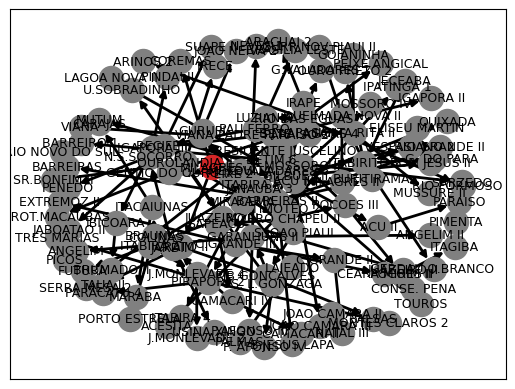

In [21]:
x = nx.bfs_tree(grafo, menos_conexões, depth_limit=10)

pos = nx.spring_layout(x, seed=100, k=0.3)

nx.draw_networkx_nodes(x, pos, nodelist=[menos_conexões], node_color="tab:red")
nx.draw_networkx_nodes(x, pos, nodelist=x.nodes - {menos_conexões}, node_color="gray")

nx.draw_networkx_edges(x, pos, width=2, alpha=1.0, edgelist=x.edges)

labels = {}
for i in x:
    labels[i] = grafo.nodes[i]["nome"]
    # print(i)


nx.draw_networkx_labels(x,pos,labels=labels, font_size=9)

Bom, ao que parece essa região está isolada do resto do grafo, provavelmente algum problema com a base de dados ou com a limpeza realizada. Usarei agora a subestação de campina grande.

In [22]:
campina_grande_II = busca_nome("C.GRANDE II")

len(vertice_alcancaveis(campina_grande_II))

361

Pode-se observar que a subestação campina grande II tem mais de 345 nodos que podem ser acessados a partir dela. Vamos observar o menor caminho entre sobradinho e campina grande, e quantos caminho possiveis existem entre a substação de campina grande e a de sobradinho(Usina hidroeletrica). **Dijkstra menor caminho**

{np.int64(897): Text(-0.7206144382077608, -0.7013821328984802, 'C.GRANDE II'),
 np.int64(3202): Text(0.5183711951125888, 0.4963150098214885, 'JUAZEIRO III'),
 np.int64(3112): Text(-0.3366952631110346, -0.30932923562723225, 'GARANHUNS II'),
 np.int64(3090): Text(-0.39124063109856777, -0.3660600001828933, 'C.GRANDE III'),
 np.int64(980): Text(-0.06982086269522449, -0.05014849665940048, 'US. L.GONZAGA'),
 118: Text(1.0, 0.9306048555465167, 'U.SOBRADINHO')}

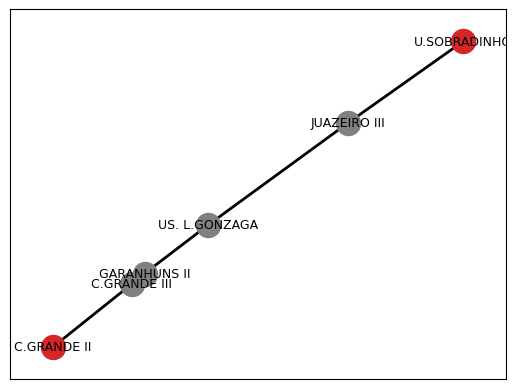

In [23]:
# achar a substação de sobradinho
sobradinho = busca_nome("U.SOBRADINHO")


# Dijkstra sobradinho campina grande II

x = grafo.subgraph(nx.algorithms.dijkstra_path(grafo, sobradinho, campina_grande_II))

pos = nx.spring_layout(x, seed=335, k=0.3)

nx.draw_networkx_nodes(x, pos, nodelist=[campina_grande_II, sobradinho], node_color="tab:red")
nx.draw_networkx_nodes(x, pos, nodelist=x.nodes - {campina_grande_II,sobradinho}, node_color="gray")

nx.draw_networkx_edges(x, pos, width=2, alpha=1.0, edgelist=x.edges)

labels = {}
for i in x.nodes:
    labels[i] = x.nodes[i]["nome"]


nx.draw_networkx_labels(x,pos,labels=labels, font_size=9)

plotando 10 caminhos diferentes entre sobradinho e campina grande

In [25]:
x = nx.algorithms.all_simple_paths(grafo, sobradinho, campina_grande_II)

cont = 0
qtd_caminhos = 2
g5 = []
for i in x:
    cont += 1
    if cont == qtd_caminhos:
        break

    g5.append(grafo.subgraph(i))
        

x = nx.compose_all(g5)

fig, ax = plt.subplots(1,1,figsize=(20,16))


pos = nx.spring_layout(x, seed=126789, k=2)

nx.draw_networkx_nodes(x, pos, nodelist=[campina_grande_II, sobradinho], node_color="tab:red",ax=ax)
nx.draw_networkx_nodes(x, pos, nodelist=x.nodes - {campina_grande_II,sobradinho}, node_color="gray",ax=ax)

nx.draw_networkx_edges(x, pos, width=2, alpha=1.0, edgelist=x.edges,ax=ax)
nx.draw_networkx_labels(x,pos, labels={campina_grande_II: x.nodes[campina_grande_II]["nome"], sobradinho : x.nodes[sobradinho]["nome"]},ax=ax)

KeyboardInterrupt: 

### Grau de centralidade

Como é possivel ver, não temos nenhum vertice sem aresta conectada a ele, mas, como observado acima nas substações do Ceará, o grafo é desconexo. Quanto a centralidade é possivel ver quantos vizinho cada vertice tem usando o atributo **degree** disponibilizado pela biblioteca. Coloquei em um dataframe pandas para melhor vizualização.

In [26]:
grau = pd.DataFrame(grafo.degree(), columns=["ide", "grau"]).set_index("ide").sort_values(by="grau", ascending=False)

In [27]:
grau.head(10)

,grau
ide,
1568,8
617,7
3111,7
676,6
4398,6
3268,6
329,6
2843,6
3368,6


In [28]:
grau.tail(10)

,grau
ide,
3182,1
3259,1
2841,1
850,1
874,1
996,1
2431,1
685,1
331,1


Plotando o grafo em relação ao grau de cada vertice (degree centrality)

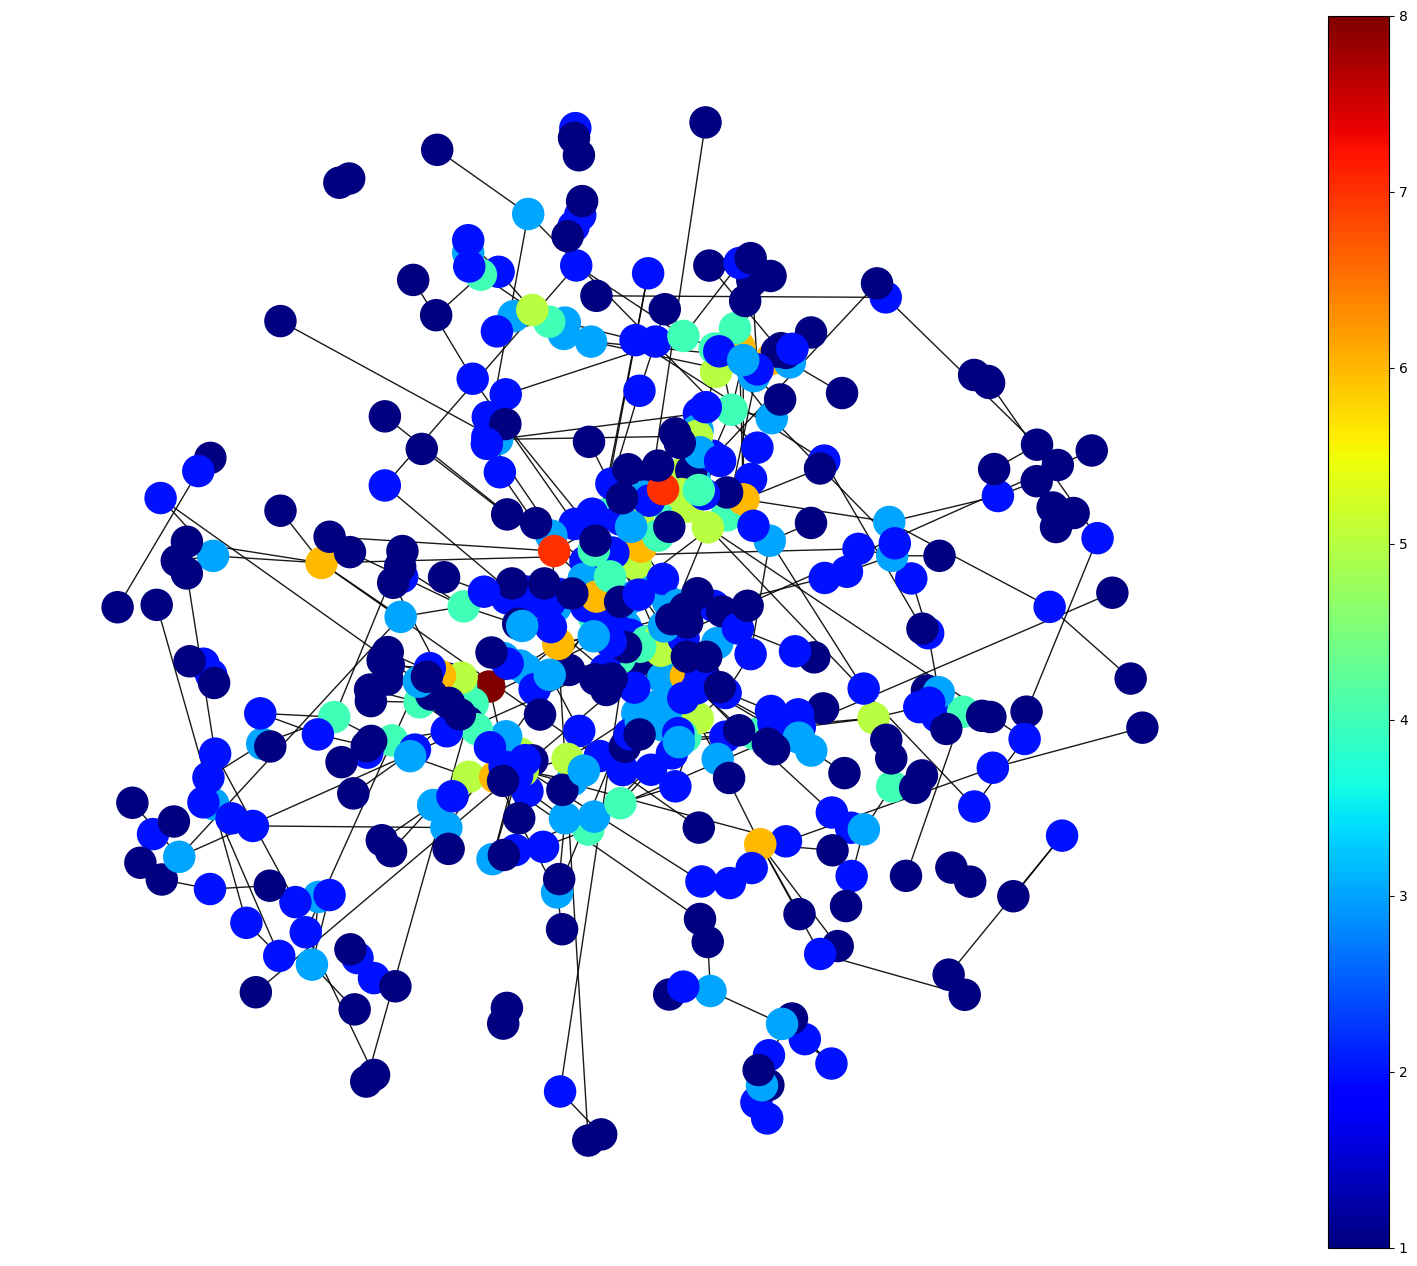

In [29]:
fig, ax = plt.subplots(1,1,figsize=(20,16))

pos = nx.spring_layout(grafo,seed=123456789,k=0.3)

color = list(dict(grafo.degree()).values())

nx.draw_networkx_edges(grafo, pos, alpha=0.9, ax=ax)
nodes = nx.draw_networkx_nodes(grafo, pos, node_color=color, node_size=500, cmap=plt.cm.jet, ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.show()



Por grau de vertice temos que as partes mais quentes tem mais conexões, isso quer dizer que ou é uma substação de uma usinas(ou um complexo), ou está em um lugar com muita atividade industrial, ou grandes centros urbanos que tendem a ter varias subestações para alimentar a cidade. E as mais frias tem menos conexões ou seja menor grau de redundância, que pode indica baixa população e produção industrial fraca. Os vertices desconexos da massa central do grafo provavelmente foram por problema na base de dados

### Verificação em relação a excentricidade

É definido como a maior distancia entre dois nós conectados, primeiramente como o grafo é desconexo, será gerado um subgrafo a partir de campina grande.

In [30]:
cg = vertice_alcancaveis(campina_grande_II)


vertices = nx.algorithms.bfs_tree(grafo, source=sobradinho, depth_limit=len(cg)*2)

sub_grafo_cg = grafo.subgraph(vertices)

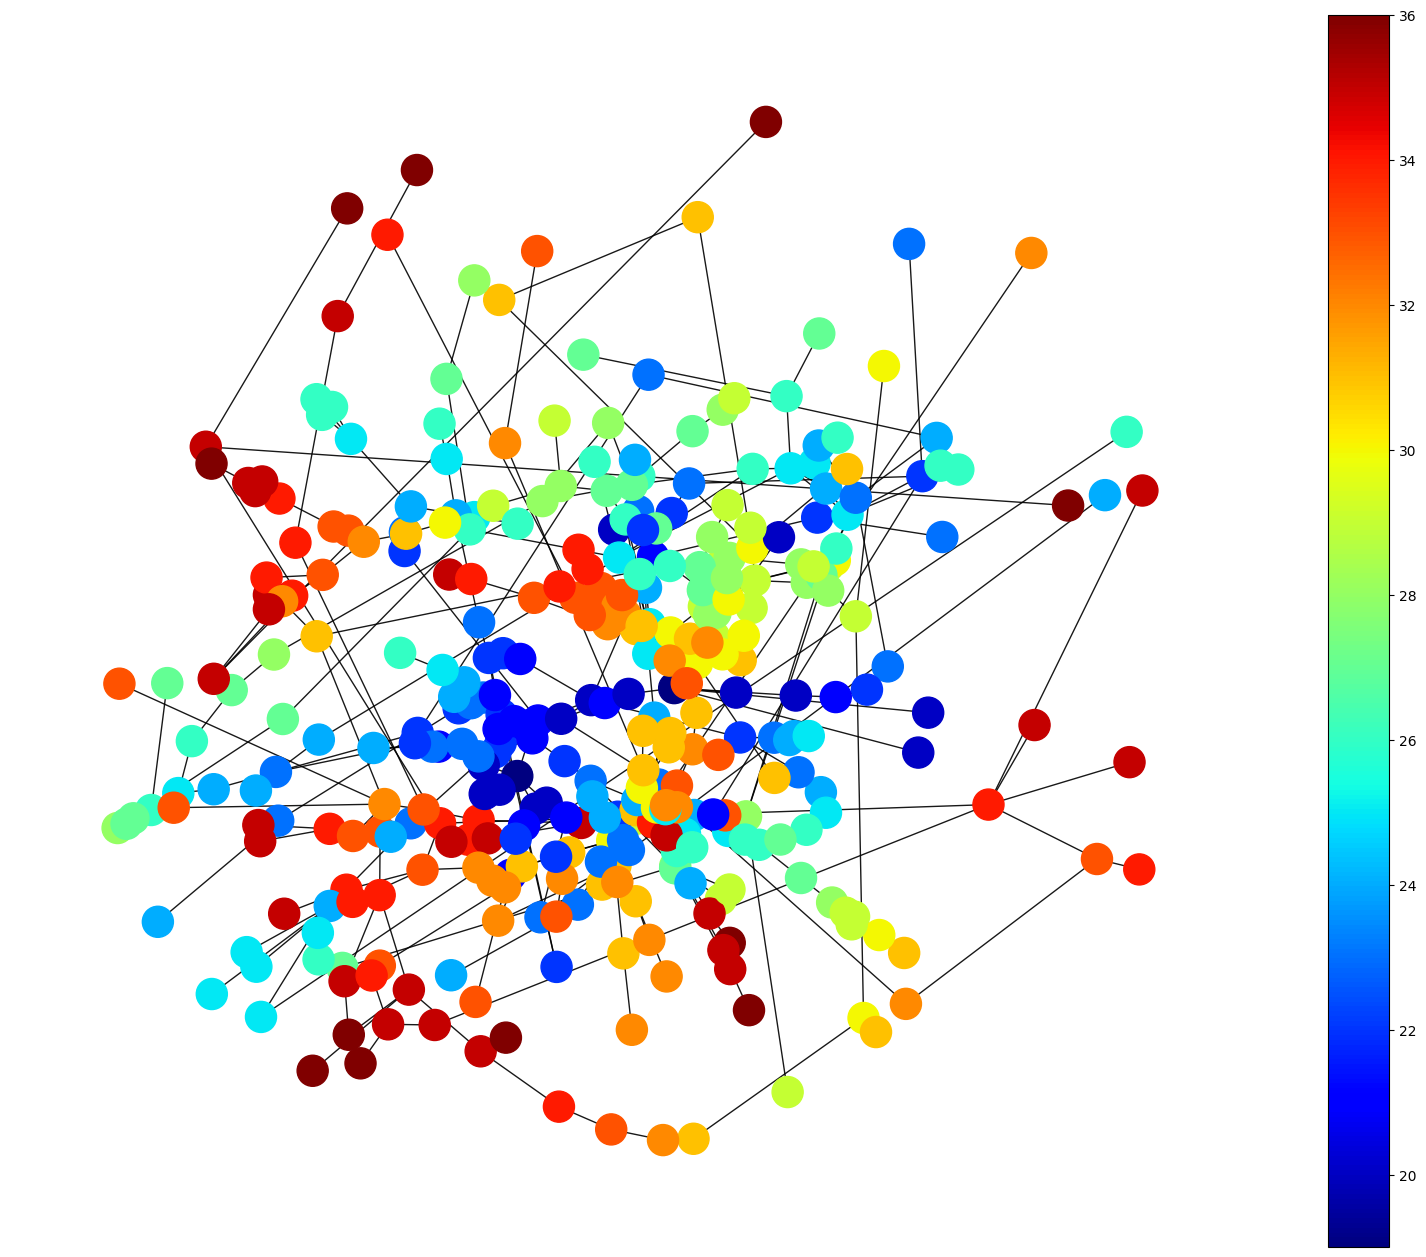

In [31]:
fig, ax = plt.subplots(1,1,figsize=(20,16))

pos = nx.spring_layout(sub_grafo_cg,seed=123456789,k=0.3)
exc = nx.eccentricity(sub_grafo_cg)
color = list(dict(exc).values())

nx.draw_networkx_edges(sub_grafo_cg, pos, alpha=0.9, ax=ax)
nodes = nx.draw_networkx_nodes(sub_grafo_cg, pos, node_color=color, node_size=500, cmap=plt.cm.jet, ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.show()


Quanto maior a excentricidade, maior a distancia e menos acessivel o vertice é, ou seja existem menos caminhos alternativos e uma maior distância de transmissão, oque leva a um perigo maior de interrupção no serviço de energia. É diferente do grau de centralização pois leva em consideração os pesos das arestas, que no caso desse grafo é a quantidade de torres de transmissão que existem entre duas substações, ou seja mais torres, mais possiveis pontos de problema.

In [32]:
diametro = nx.diameter(sub_grafo_cg)

print("Diametro do grafo é igual a {}".format(diametro))

for k in exc.keys():
    if(exc[k] >= diametro):
        print(sub_grafo_cg.nodes[k]["nome"], end=" - ")
    

Diametro do grafo é igual a 36
PARAISO - PIRAPAMA II - MOSSORO IV - CASCAVEL - SUAPE III - NATAL II - PORTO ALEGRE 10 - JARDIM BOTANICO - MACEIO II - PARAGUACU PAULISTA II - CHARQUEADAS - 

Como visto o diametro do grafo é igual a 37 e as três substações seriam as de mais dificil acesso, ou seja mais vulneraveis a problemas de distribuição de energia.
Veremos Maceio II

In [33]:
maceio_II = busca_nome("MACEIO II")

{np.int64(897): Text(-0.8503733804167501, -0.6066377564534401, 'C.GRANDE II'),
 np.int64(3202): Text(0.5230946262918627, 0.36897334452357383, 'JUAZEIRO III'),
 np.int64(1410): Text(-0.03519226742489651, -0.5317425163399401, 'PARAISO'),
 np.int64(1797): Text(0.059253488001665994, 0.906535123858329, 'JARDIM'),
 np.int64(907): Text(-0.8785727511902741, -0.17409389388748348, 'MUSSURE II'),
 np.int64(16): Text(-0.4073702585026544, 0.642088485387844, 'MESSIAS'),
 np.int64(3090): Text(0.18802987348951525, -0.10826438495805693, 'C.GRANDE III'),
 np.int64(19): Text(0.9325227181407366, -0.14151280243885828, 'PENEDO'),
 np.int64(915): Text(0.17834615958160405, 0.3259863060500314, 'ANGELIM II'),
 np.int64(21): Text(0.3339773476372051, 0.6169996117577262, 'RIO LARGO II'),
 np.int64(916): Text(-0.8864762796384846, 0.38240090837914, 'ANGELIM'),
 np.int64(3092): Text(0.19860741914561028, -0.26378846114464155, 'CEARA MIRIM II'),
 np.int64(3091): Text(-0.1791566227503093, -0.03650888908421394, 'JOAO CAM

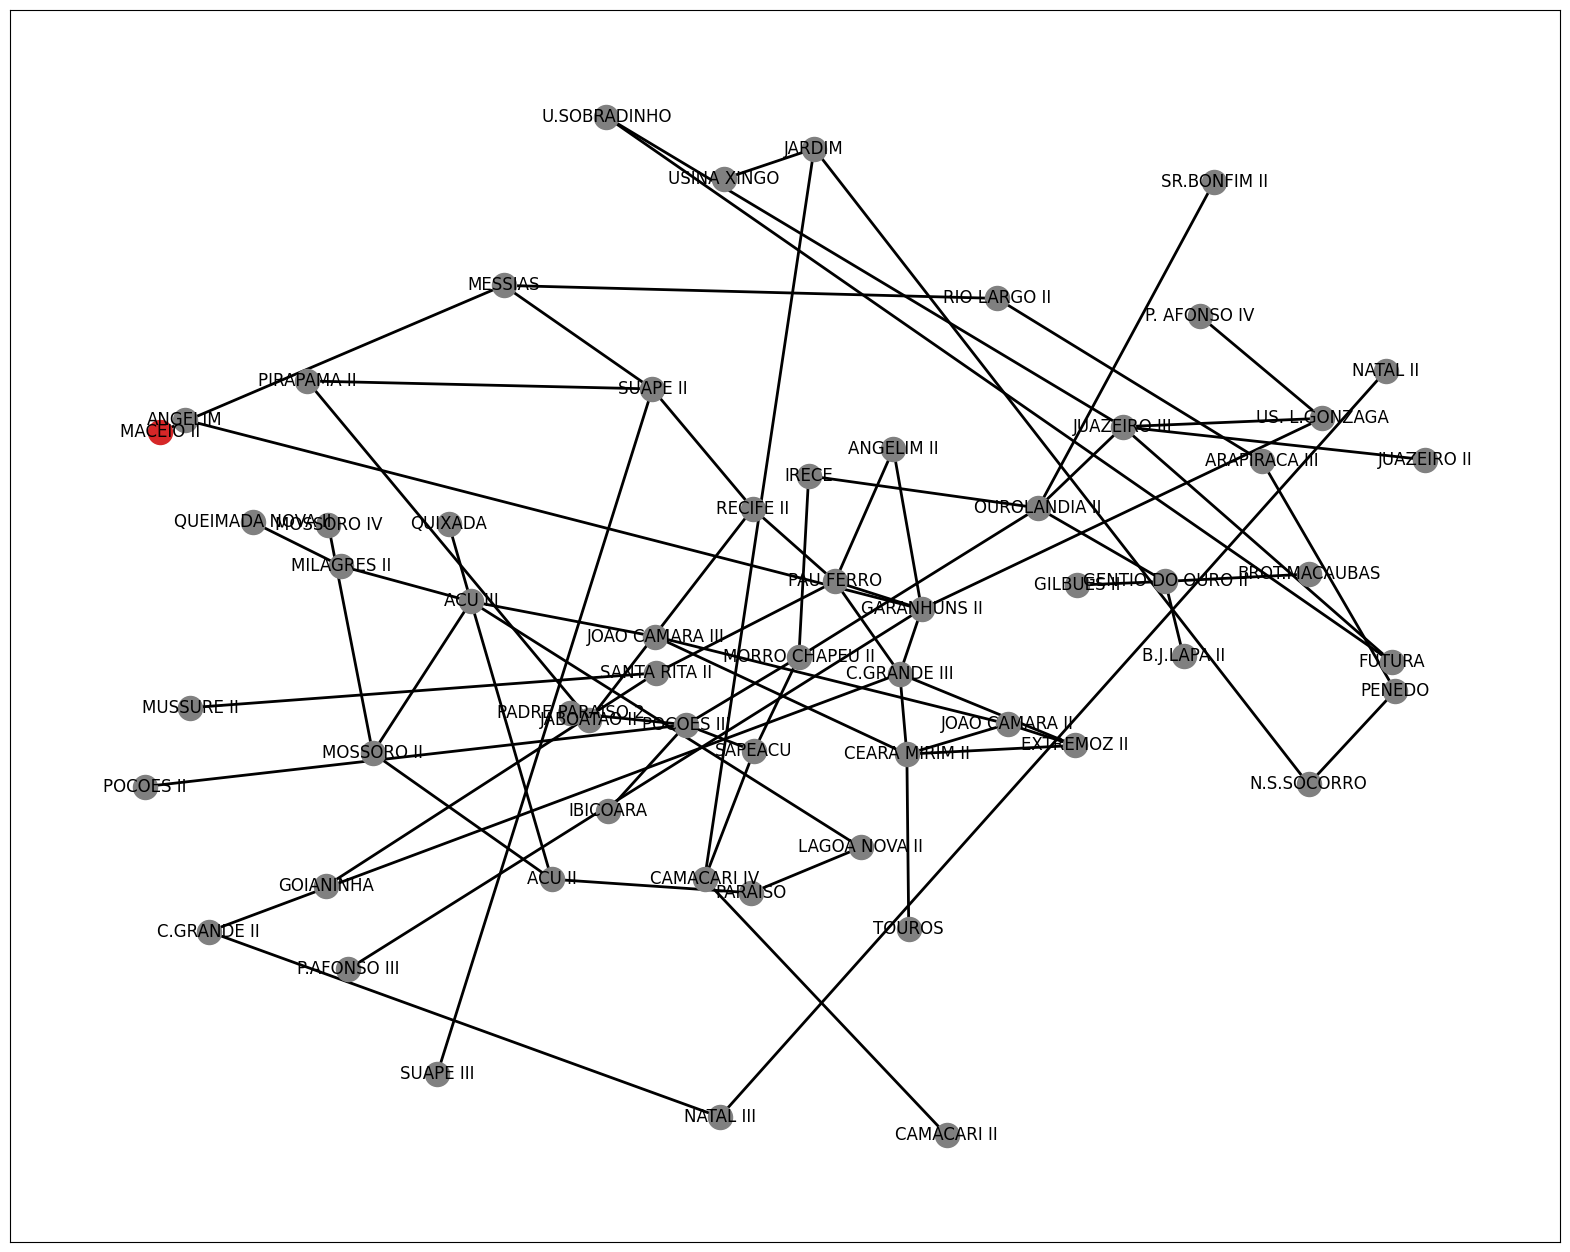

In [34]:
tree_maceio = sub_grafo_cg.subgraph(nx.algorithms.bfs_tree(grafo,maceio_II, depth_limit=10))
x = tree_maceio

fig, ax = plt.subplots(1,1,figsize=(20,16))


pos = nx.spring_layout(x, seed=126789, k=2)

nx.draw_networkx_nodes(x, pos, nodelist=[maceio_II], node_color="tab:red",ax=ax)
nx.draw_networkx_nodes(x, pos, nodelist=x.nodes - {maceio_II}, node_color="gray",ax=ax)

nx.draw_networkx_edges(x, pos, width=2, alpha=1.0, edgelist=x.edges,ax=ax)
labels = {}
for i in tree_maceio.nodes:
    labels[i] = tree_maceio.nodes[i]["nome"]

nx.draw_networkx_labels(x,pos, labels=labels,ax=ax)

Como pode-se ver a substração **MACEIO II** tem uma única ponte entre ela e o resto da rede, ou seja se ocorrer algum problema na subestação de **MESSIAS** inevitávelmente MACEIO II e todos os consumidores que dependem da substação estariam com a energia elétrica cortada. E considerando que o grafo gerado é um subgrafo com vertices disponibilizados pelo algorimo de busca em largura, é visivel que existe problemas de redundancia nessa rede e que a energia pode facilmente se tornar indisponivel para essa subestação.

# <center> Considerações finais</center>

Primeiramente, os dados provavelmente estão incompletos ou desatualizados, oque é compreesivel até pq a infraestrutura de energia elétrica é algo de vital importância para a segurança nacional, e simplesmente disponibilizar uma visão completa dela ao publico não seria um decisão muito inteligente. Mesmo assim busquei outros dados para ver se conseguia adicionar mais coisas e não achei, e os que achei não me davam oque eu queria.

Bom obviamente existem varias outras coisas que podem ser feitas com o grafo nessa forma, por exemplo foi detectado um possivel falha de infraestrutura na substação de maceio, tenho plena convicção que até mesmo pelo nome da substação e por ser uma capital de um estado exista mais de uma conexão, além de messias para garantir uma distribuição adequada de energia para a população da capital. 